### Wakefield simulation of the SPS trantisions with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity 
* Calculation of the longitudinal wake potential and impedance
* Plotting in 3d, 2d, 1d of the results

| Model                                                                                                                                                                  | Long. Wake $W_{\parallel}$                                                          | Long. Impedance $Z_{\parallel}$                                                                                                                                          | Dipolar X Wake $W_{\perp,x}$ | Dipolar X Impedance $Z_{\perp,x}$    |
| ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ---------------------------- | --- |
| ![](https://codimd.web.cern.ch/uploads/upload_e000d07cadd11564621cc40e3ee860e4.png)![](https://codimd.web.cern.ch/uploads/upload_1119d302906ecce90b0a35de9e3d6467.png)![](https://codimd.web.cern.ch/uploads/upload_b2e8aaa13fc797dea35fbcd49863c757.png) | ![](https://codimd.web.cern.ch/uploads/upload_a2d489bd479fe133d21358c45c098943.png) | ![](https://codimd.web.cern.ch/uploads/upload_eedc218d2fbfae6791b5c8a845c58fa6.png)  ![](https://codimd.web.cern.ch/uploads/upload_ee0b03db38c10781251a7273ddfdffac.png) |         xsource=0 ![](https://codimd.web.cern.ch/uploads/upload_d2b2c623154a593bb0411db359d88cc8.png) xsource=5  ![](https://codimd.web.cern.ch/uploads/upload_a5b03234bc95d0838a22899e235dad5a.png)   |   xsource=0 ![](https://codimd.web.cern.ch/uploads/upload_4b5e2762993e4ea576d2de9aca6c4a76.png) xsource=5 ![](https://codimd.web.cern.ch/uploads/upload_9d4b7860cf1a22eaf5c8a2b0a51c0838.png) |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl

### Domain setup and grid generation

#### Check geometry STL

In [ ]:
# # [Optional] import STP
# from wakis import geometry
# stl_solids = geometry.generate_stl_solids_from_stp('SPS_trans_QF_B2_new.stp')

In [ ]:
# Construct transition geometry
pipe = pv.Cylinder(radius=76, height=300, direction=(0,0,1), center=(0,0,0)).scale([0.252, 1, 1]).scale(1e-3)
cyl = pv.Cylinder(radius=76, height=13.5, direction=(0,0,1), center=(0,0,0)).scale(1e-3)

#pipe.save('SPS_trans_QF_B2_pipe_m.stl')
#cyl.save('SPS_trans_QF_B2_cyl_m.stl')

trans = pipe.triangulate() | cyl.triangulate()
trans.save('SPS_trans_QF_B2_merged_m.stl')

# pl = pv.Plotter()
# pl.add_mesh(pipe, color='blue', opacity=0.5)
# pl.add_mesh(cyl, color='red', opacity=0.5)
# pl.add_mesh(trans, color='black', opacity=0.5)
# pl.add_axes()
# pl.show()

#### Setup grid

In [2]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 80
Ny = 80
Nz = 200
#dt = 2.187760221e-12 # like CST

# Domain bounds
surf = pv.read('SPS_trans_QF_B2_merged_m.stl')
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)

stl_solids = {'transition': 'SPS_trans_QF_B2_merged_m.stl'}
stl_materials = {'transition': 'vacuum'}

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, 
                Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                #stl_scale=1e-3, # [mm] to [m]
                stl_tol=1e-3,
                )

Generating grid...
Importing STL solids...


#### A few examples of quick geometry, mesh and domain visualization in 3D to inspect the generated grid and imported solids:

In [ ]:
grid.plot_stl_mask('transition', add_stl='all',
                   stl_opacity=0.1, 
                   show_grid=False, bounding_box=False)

In [ ]:
# Plot the imported geometry 3d interactive plot
grid.plot_solids()

In [ ]:
# Plot the geometry and the grid on 3d interactive plot
grid.inspect()

### Boundary conditions and EM solver

In [3]:
# boundary conditions
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']
n_pml = 10

solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     n_pml=n_pml,
                     use_stl=True, 
                     bg='pec')

# solver.pml_hi = 100
# solver.pml_func = np.linspace
# solver.fill_pml_sigmas()

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Filling PML sigmas...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.9762370586395264 s


#### A few examples on how to inspect the generated fields `E`, `H`, `J`, and material tensors `sigma` (conductivity $\sigma$), `ieps` ($\varepsilon^{-1}$), `imu` ($\mu^{-1}$) 

In [ ]:
solver.ieps.inspect3D(field='x', ymax=0, grid=grid, show_grid=False, backend='pyvista')

In [ ]:
# Inspect the material tensors before running the simulations
solver.ieps.inspect(plane='XZ', dpi=150, figsize=[9, 6]) 

### Wakefield settings & Run

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 15e-3      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 5. #[m]
add_space = 15   # no. cells
results_folder = 'results/'
wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                add_space=add_space,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength

In [5]:
solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 add_space=add_space,
                 plot=False)

Running electromagnetic time-domain simulation...


100%|██████████| 10845/10845 [18:03<00:00, 10.01it/s]  


Reading h5 file results/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|██████████| 92241/92241 [00:22<00:00, 4054.34it/s]


Calculating transverse wake potential WPx, WPy...


100%|██████████| 92241/92241 [00:00<00:00, 211418.40it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


### Plotting of results

Easily access the Wakefield simulation result stored in the `WakeSolver` attributes:
* Longitudinal: s, WP, Z
* Transverse: s, WPx, WPy, Zx, Zy
* Charge distribution [C/m]: s, lambdas

In [18]:
wake.solve(skip_cells=20)

Calculating longitudinal wake potential WP(s)


  0%|          | 0/92241 [00:00<?, ?it/s]

100%|██████████| 92241/92241 [00:19<00:00, 4827.09it/s]


Calculating transverse wake potential WPx, WPy...


100%|██████████| 92241/92241 [00:00<00:00, 216599.51it/s]

Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


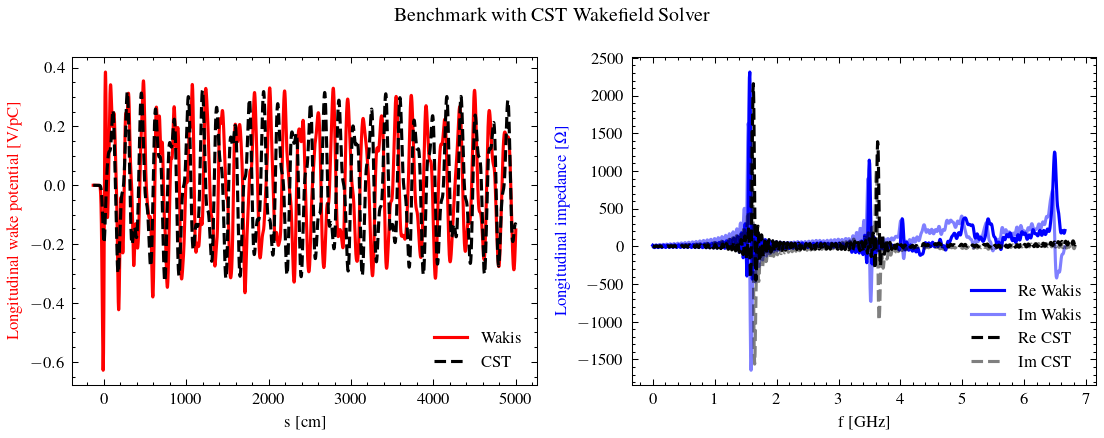

In [23]:
# For scientific paper-like plots 
import scienceplots
plt.style.use(['science','ieee'])

# Compare to benchmark data, if available
compare_to_CST = True

fig, ax = plt.subplots(1,2, figsize=[7.5,3], dpi=150)
ax[0].plot(wake.s*1e3, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Re Wakis')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', ls='-', lw=1.5, alpha=0.5, label='Im Wakis')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [$\Omega$]', color='b')

if compare_to_CST:
    # CST wake and impedace data:
    cstWP = wake.read_txt('cst/SPS_trans_QF_B2_new_WPz_xbeam5..txt')
    cstZ = wake.read_txt('cst/SPS_trans_QF_B2_new_Zz_xbeam5..txt')
    ax[0].plot(cstWP[0], cstWP[1], c='k', ls='--', lw=1.5, label='CST')
    ax[1].plot(cstZ[0], cstZ[1], c='k', ls='--', lw=1.5, label='Re CST')
    ax[1].plot(cstZ[0], cstZ[2], c='k', ls='--', lw=1.5, alpha=0.5, label='Im CST')
    fig.suptitle('Benchmark with CST Wakefield Solver')

ax[0].legend()
ax[1].legend()
fig.tight_layout()
fig.savefig(results_folder+'benchmark_z.png', dpi=300)